# Notebook to plot HNL constraints

This notebook runs through the process of getting the 0-th order constraints from T2K

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
from scipy import interpolate

from matplotlib import rc, rcParams
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import pathos.multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

from functools import partial

from particle import *
from particle import literals as lp

In [6]:
from HNL_MC import *
from HNL_MC import hnl_tools
from HNL_MC.const import *

# Neutrino fluxes 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: computer modern roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: computer modern roman


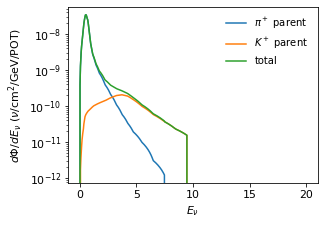

In [7]:
nd280fhc = exp.experiment(exp.ND280_FHC)
fpi = nd280fhc.get_flux_func(parent=lp.pi_plus)
fK = nd280fhc.get_flux_func(parent=lp.K_plus)

fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

x=np.linspace(0,20,1000)
ax.plot(x,fpi(x), label='$\pi^+$ parent')
ax.plot(x,fK(x), label='$K^+$ parent')
ax.plot(x,fpi(x) + fK(x), label='total')

ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"$d\Phi/dE_\nu$ ($\nu$/cm$^2$/GeV/POT)")
ax.set_yscale('log')
ax.legend(loc='upper right', frameon=False)
ax.patch.set_facecolor('None')
fig.savefig("plots/nd280_FHC_nufluxes.png", dpi=400)

# Shrock Function

/home/nic/Dropbox/Dark_coherent_scattering/stdHNL/HNL_MC/const.py:158: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(kallen(a,b,c))
/home/nic/Dropbox/Dark_coherent_scattering/stdHNL/HNL_MC/const.py:158: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(kallen(a,b,c))
/home/nic/Dropbox/Dark_coherent_scattering/stdHNL/HNL_MC/const.py:158: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(kallen(a,b,c))


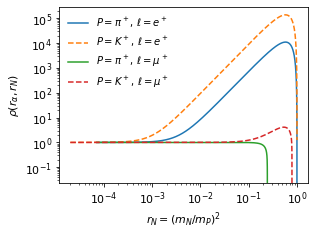

In [8]:
mN_K = np.logspace(-5,np.log10(lp.K_plus.mass/1e3),10000, endpoint=False)
mN_pi = np.logspace(-5,np.log10(lp.pi_plus.mass/1e3),10000, endpoint=False)

fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

ax.plot(mN_pi/(lp.pi_plus.mass/1e3), hnl_tools.get_Rapp(mN_pi, parent = lp.pi_plus, daughter = lp.e_plus), label=r'$P=\pi^+,\,\ell=e^+$')
ax.plot(mN_K/(lp.K_plus.mass/1e3), hnl_tools.get_Rapp(mN_K, parent = lp.K_plus, daughter = lp.e_plus), label=r'$P=K^+,\,\ell=e^+$',ls='--')

ax.plot(mN_pi/(lp.pi_plus.mass/1e3), hnl_tools.get_Rapp(mN_pi, parent = lp.pi_plus, daughter = lp.mu_plus), label=r'$P=\pi^+,\,\ell=\mu^+$')
ax.plot(mN_K/(lp.K_plus.mass/1e3), hnl_tools.get_Rapp(mN_K, parent = lp.K_plus, daughter = lp.mu_plus), label=r'$P=K^+,\,\ell=\mu^+$',ls='--')

ax.set_ylabel(r"$\rho(r_\alpha,r_N)$")
ax.set_xlabel(r"$r_N=(m_N/m_P)^2$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc='upper left', frameon=False)
ax.patch.set_facecolor('None')
fig.savefig("plots/rho_function.png", dpi=400)

# Approximation for HNL flux

M_N = 0.15, T2K = 3e-09, Matheus = 2.5e-09, ratio = 0.85
M_N = 0.25, T2K = 8.5e-09, Matheus = 3.7e-09, ratio = 0.44


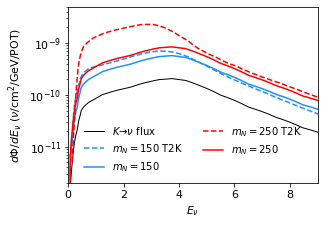

In [39]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)
USQR = 1

x=np.linspace(0,10,1000)

#\nu 
ax.plot(x,fK(x), label=r'$K\to\nu$ flux', color= 'black', lw = 1)
# ax.plot(x,fK(x), label=r'$K^+$ parent', color='orange')

MN = 0.150

EN, flux = np.genfromtxt("digitized/T2K_HNL_fluxes/m4_150_MeV_KmuN.dat", unpack = True)
ax.plot(EN,USQR*flux/1e21, label=r'$m_N = 150$ T2K', ls='--', color='dodgerblue')

aux_dEN = np.array([2*EN[0] - EN[1]]+EN.tolist()+[2*EN[-1] - EN[-2]])
dEN = (aux_dEN[2:]-aux_dEN[:-2])/2

# phiN_pi = hnl_tools.dphi_dEN_app(fpi, x, Ualpha4SQR=USQR, mN=MN, parent=lp.pi_plus, daughter=lp.mu_plus)
phiN_K = hnl_tools.dphi_dEN_app(fK, x, Ualpha4SQR=USQR, mN=MN, parent=lp.K_plus, daughter=lp.mu_plus)
# ax.plot(x,phiN_pi, label=r'$\pi^+ \to \mu^+ N$', ls='--', color= 'dodgerblue')
ax.plot(x,phiN_K, label=r'$m_N = 150$', ls='-', color='dodgerblue')

print(f'M_N = {MN}, T2K = {USQR*(flux*dEN).sum()/1e21:.2g}, '+\
      f'Matheus = {(x[1]-x[0])*phiN_K.sum():.2g}, '+\
      f'ratio = {(x[1]-x[0])*phiN_K.sum()/(USQR*(flux*dEN).sum()/1e21):.2g}')

      
MN = 0.250

EN, flux = np.genfromtxt("digitized/T2K_HNL_fluxes/m4_250_MeV_KmuN.dat", unpack = True)
ax.plot(EN,USQR*flux/1e21, label=r'$m_N = 250$ T2K', ls='--', color='red')

aux_dEN = np.array([2*EN[0] - EN[1]]+EN.tolist()+[2*EN[-1] - EN[-2]])
dEN = (aux_dEN[2:]-aux_dEN[:-2])/2

# phiN_pi = hnl_tools.dphi_dEN_app(fpi, x, Ualpha4SQR=USQR, mN=MN, parent=lp.pi_plus, daughter=lp.mu_plus)
phiN_K = hnl_tools.dphi_dEN_app(fK, x, Ualpha4SQR=USQR, mN=MN, parent=lp.K_plus, daughter=lp.mu_plus)
# ax.plot(x,phiN_pi, label=r'$\pi^+ \to \mu^+ N$', ls='--', color= 'dodgerblue')
ax.plot(x,phiN_K, label=r'$m_N = 250$', ls='-', color='red')


print(f'M_N = {MN}, T2K = {USQR*(flux*dEN).sum()/1e21:.2g}, '+\
      f'Matheus = {(x[1]-x[0])*phiN_K.sum():.2g}, '+\
      f'ratio = {(x[1]-x[0])*phiN_K.sum()/(USQR*(flux*dEN).sum()/1e21):.2g}')

ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"$d\Phi/dE_\nu$ ($\nu$/cm$^2$/GeV/POT)")
ax.set_yscale('log')
ax.set_ylim(2e-12,5e-9)
ax.set_xlim(0,9)
ax.legend(loc='lower center', frameon=False, ncol=2)
ax.patch.set_facecolor('None')
fig.savefig("plots/HNL_fluxes_mN_150.png", dpi=400)

In [29]:
aux = np.array([2*EN[0] - EN[1]]+EN.tolist()+[2*EN[-1] - EN[-2]])

In [36]:
EN.shape

(59,)

In [32]:
aux2 = aux[1:] - aux[:-1]

In [35]:
(aux[2:]-aux[:-2]).shape

(59,)

# Decay Rates

In [13]:
UMU4 = np.sqrt(1e-4)
my_hnl = model.hnl_model(m4=0.120, mixings=[0.0,UMU4, 0.0])
my_hnl.set_high_level_variables()
my_hnl.compute_rates()

## Ue4

In [14]:
# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.300),100)
USQR = 1e-6
ctaus=[]
for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[np.sqrt(USQR),0, 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    ctaus.append(my_hnl.ctau0)
ctaus=np.array(ctaus)

No handles with labels found to put in legend.


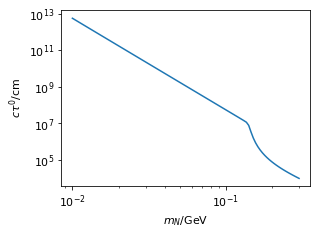

In [15]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

ax.plot(M4,ctaus)
 
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"$c\tau^0/$cm")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/lifetime_e-only.png", dpi=400)

In [16]:
# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.4),100)
USQR = 1e-2

list_of_channels = ['nu_nu_nu','nu_e_e','nu_e_mu','nu_mu_mu','nu_pi','e_pi','mu_pi']
all_brs = np.empty((len(list_of_channels),len(M4)))

for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[np.sqrt(USQR),0.0, 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    for channel in list_of_channels:
        
        i = list_of_channels.index(channel)
        
        if channel in my_hnl.brs:
            all_brs[i,j] = my_hnl.brs[channel]
        else:
            all_brs[i,j] = 0.0

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: computer modern roman


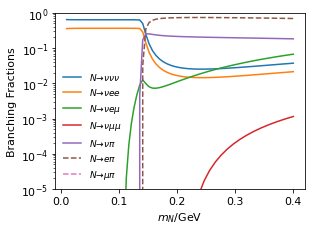

In [17]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

for channel in list_of_channels:
    i = list_of_channels.index(channel)
    label=f'$N\\to {channel}$'.replace("_", " ").replace("nu", '\\nu').replace("mu", '\\mu').replace("pi", '\\pi')
    
    if channel[:2] != "nu":
        s='--'
    else:
        s='-'
    
    ax.plot(M4, all_brs[i,:], label=label, linestyle=s)
            
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"Branching Fractions")
ax.set_yscale('log')
ax.set_ylim(1e-5,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/Branching_ratios_e-only.png", dpi=400)

## Umu4

In [18]:
# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.300),20)
USQR = 1e-2
ctaus=[]
for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[0.0,np.sqrt(USQR), 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    ctaus.append(my_hnl.ctau0)
ctaus=np.array(ctaus)

No handles with labels found to put in legend.


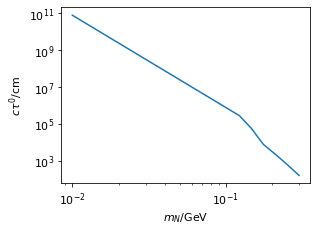

In [19]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

ax.plot(M4,ctaus)
 
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"$c\tau^0/$cm")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/lifetime_mu-only.png", dpi=400)

In [77]:
tot_cores = mp.cpu_count()
pool = Pool(tot_cores)
############

# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.300),200)
USQR = 1e-2

list_of_channels = ['nu_nu_nu','nu_e_e','nu_e_mu','nu_mu_mu','nu_pi','e_pi','mu_pi']
all_brs = np.empty((len(list_of_channels),len(M4)))

for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[0.0,np.sqrt(USQR), 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    for channel in list_of_channels:
        i = list_of_channels.index(channel)
        
        if channel in my_hnl.brs:
            all_brs[i,j] = my_hnl.brs[channel]
        else:
            all_brs[i,j] = 0.0

############
pool.terminate()
pool.restart()

<multiprocess.pool.Pool state=RUN pool_size=8>

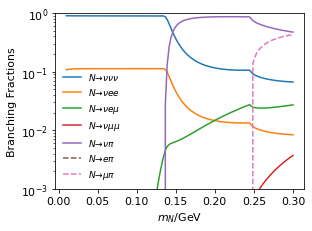

In [78]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

for channel in list_of_channels:
    i = list_of_channels.index(channel)
    label=f'$N\\to {channel}$'.replace("_", " ").replace("nu", '\\nu').replace("mu", '\\mu').replace("pi", '\\pi')
    
    if channel[:2] != "nu":
        s='--'
    else:
        s='-'
    
    ax.plot(M4, all_brs[i,:], label=label, linestyle=s)
            
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"Branching Fractions")
ax.set_yscale('log')
ax.set_ylim(1e-3,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/Branching_ratios_mu-only.png", dpi=400)

# Compute number of decays in TPCs

In [33]:
# tests
hnl_tools.get_event_rate((0.300, 1e-6), flavor_struct=[0.0,1.0,0.0], exp_setup=exp.ND280_FHC)
# print(hnl_tools.get_lifetime((0.150, 1e-0), flavor_struct=[0.0,0.0,1.0]))
# print(hnl_tools.get_lifetime((0.300, 1e-0), flavor_struct=[0.0,0.0,1.0]))

3644.4385394114774

## Batch computation

In [34]:
# grid of mix vs mass
gridx = 50
gridy = 20

M4 = np.logspace(np.log10(0.1), np.log10(0.388), gridx)
USQR = np.logspace(-10,-5, gridy) 
X,Y = np.meshgrid(M4,USQR)
m4_grid, usqr_grid = X.flatten(), Y.flatten()

# run event rate calc ß


tot_cores = mp.cpu_count()
pool = Pool(tot_cores)
############

get_event_partial = partial(hnl_tools.get_event_rate, flavor_struct=[0.0,1.0,0.0], exp_setup = exp.ND280_FHC)
event_rate = pool.map(get_event_partial, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))

get_lifetime_partial = partial(hnl_tools.get_event_rate, flavor_struct=[0.0,1.0,0.0])
lifetime = pool.map(hnl_tools.get_lifetime, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))

############
pool.terminate()
pool.restart()

<multiprocess.pool.Pool state=RUN pool_size=8>

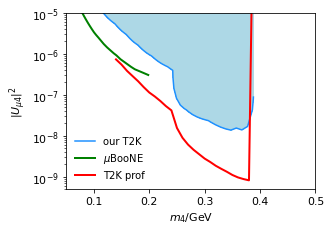

In [35]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)
ax.patch.set_facecolor('None')

# T2K estimate
Xi,Yi,Zi=plot_style.interp_grid(x=m4_grid, y=usqr_grid , z=event_rate, fine_gridx=gridx, fine_gridy=gridy, log=True)
# get contour x and y
_ = ax.contourf(Xi, Yi, Zi, levels = [2.3,1e100], colors=['lightblue']) #NEW CONSTRAINT
level_0 = ax.contour(Xi, Yi, Zi, levels = [2.3], colors=['None']) #NEW CONSTRAINT
bound = level_0.collections[0].get_paths()[0].vertices  #grab the coords of the bound
ax.plot(bound[:,0],bound[:,1], c='dodgerblue', label=r'our T2K')

# level_0 = ax.contour(Xi, Yi, np.log10(Zi), levels = 20) #NEW CONSTRAINT

# ctau = 0.1 s
# Xi,Yi,Zi=plot_style.interp_grid(x=m4_grid, y=usqr_grid , z=lifetime, fine_gridx=gridx, fine_gridy=gridy, log=True)
# level_1 = ax.contour(Xi, Yi, Zi, levels = [0.1*const.c_LIGHT], colors=['None'], linestyles=['--']) #NEW CONSTRAINT
# bound = level_1.collections[0].get_paths()[0].vertices  #grab the coords of the bound
# ax.plot(bound[:,0],bound[:,1], c='black', ls=':', label=r'$\tau^0 = 1$ s')


# Kelly Machado 
mbound,ubound = np.genfromtxt('digitized/muboone_kelly_machado/PS_eff_scalar.dat',unpack=True)
plt.plot(mbound/1e3,ubound, c='green', lw=2, ls='-', label='$\mu$BooNE')
# mbound,ubound = np.genfromtxt('digitized/muboone_kelly_machado/PS_eff_avg.dat',unpack=True)
# plt.plot(mbound/1e3,ubound, c='green', lw=2, ls='--', label='Kelly \& Machado')

# Kusenko
# mbound,ubound = np.genfromtxt('digitized/Kusenko/Umu4_v2.dat',unpack=True)
# plt.plot(mbound/1e3,ubound, c='orange', lw=2, ls='-', label='PS191')

# T2K bound
# mbound,ubound = np.genfromtxt('digitized/T2K_2019/T2K_2019_mu.dat',unpack=True)
# plt.plot(mbound/1e3,ubound, c='red', lw=2, label='T2K official')
# mbound,ubound = np.genfromtxt('digitized/T2K_2019/T2K_2019_mu_single_channel.dat',unpack=True)
# plt.plot(mbound/1e3,ubound, c='red', lw=2, ls='--', label='T2K official')

m4, ue4, Umu4 = np.genfromtxt('limits_profiling.dat', unpack=True)
plt.plot(m4/1e3,Umu4, c='red', lw=2, ls='-', label='T2K prof')




ax.set_yscale("log")
# ax.set_xscale("log")

ax.set_ylabel("$|U_{\mu 4}|^2$")
ax.set_xlabel("$m_4/$GeV")

ax.legend(loc='lower left', frameon=False, ncol=1)
ax.set_ylim(5e-10,1e-5)
ax.set_xlim(5e-2,0.5)
fig.savefig('plots/T2K_bound.png',dpi=400)

In [23]:
# Main plot for Muons

NameError: name 'umu4' is not defined

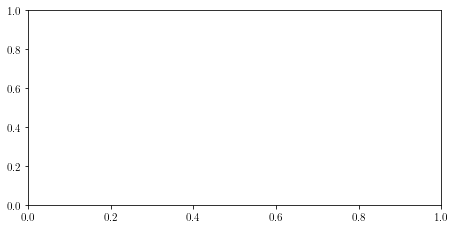

In [24]:
def plot_lines(flavor, save=False, invisible=False, m4min=1e-3,m4max=1e2, units = 1):
    fsize = 11
    rc('text', usetex=True)
    params={'axes.labelsize':fsize,'xtick.labelsize':fsize,'ytick.labelsize':fsize,\
                    'figure.figsize':(2*3.375,1.5*2.375)	}
    rc('font',**{'family':'serif', 'serif': ['computer modern roman']})
    rcParams.update(params)
    axes_form  = [0.1,0.16,0.85,0.76]


    fig = plt.figure()
    ax = fig.add_axes(axes_form)


    #############
    # get bounds
    list_of_bounds=umu4.get_individual_bounds(muon_bounds, m4min=m4min, m4max=m4max)

    for key in list_of_bounds.keys():
        MN,usqr_bound = list_of_bounds[key]
        ##############################################
        # Constraints on U\alpha4^2
#         ax.plot(MN*units, usqr_bound, label=fr"{key.split('_')[0]}")
        ax.fill_between(MN*units, usqr_bound, np.ones(np.size(MN)), 
                        fc='lightgrey', ec='None', lw =0.0, alpha=0.5)



    ax.set_xlim(m4min*units,m4max*units)
    ax.set_ylim(1e-9,2e-2)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel(label[flavor])
    ax.set_xlabel(r"$m_{N}$/MeV")
    ax.set_yticks([1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3,1e-2])
    ax.grid(axis='y', which='both',dashes=(6,1),alpha=0.5,c='black',lw=0.2)
    if save:
        fig.savefig('plots/u'+flavor+'4.pdf')
    return ax, fig

axmu, figmu = plot_lines('mu',m4min=0.02,m4max=0.2,units=1e3)

x = np.logspace(np.log10(20),np.log10(200), 1000)

##
this_file = 'digitized/muboone_kelly_machado/PS_eff_avg.dat'
m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
units = 1
f = interpolate.interp1d(m4*units, Umu4sq, kind='linear', bounds_error=False, fill_value=None, assume_sorted=False)    
axmu.plot(x, f(x), c='black', ls='-', label='Kelly \& Machado 1')

##
this_file = 'digitized/muboone_kelly_machado/PS_eff_scalar.dat'
m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
units = 1
f = interpolate.interp1d(m4*units, Umu4sq, kind='linear', bounds_error=False, fill_value=None, assume_sorted=False)    
axmu.plot(x, f(x), c='black', ls='--', label='Kelly \& Machado 2')


##
this_file = 'Nlimits/digitized/PS-191/UeUmu_K.dat'
m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
fK = interpolate.interp1d(m4*units, Umu4sq, kind='linear', bounds_error=False, fill_value=1, assume_sorted=False)    

this_file = 'Nlimits/digitized/PS-191/UeUmu_pi.dat'
m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
fpi = interpolate.interp1d(m4*units, Umu4sq, kind='linear', bounds_error=False, fill_value=1, assume_sorted=False)    

gL = -1/2 + 0.223
gR = 0.22343
scaling = np.sqrt(gL**2 +gR**2 + gR*gL)
combined = np.amin([fK(x),fpi(x)],axis=0)

NBAKGS = 30**2
lower_line = combined/scaling
upper_line = combined/scaling*np.sqrt(np.sqrt(NBAKGS)/2.3)

axmu.fill_between(x, lower_line, upper_line, color='lightblue', lw=0.0)
axmu.plot(x, lower_line, color='dodgerblue', ls='-', label=fr'my PS-191 $N_{{\rm bkg}}=0$')
axmu.plot(x, upper_line, color='dodgerblue', ls='--', label=fr'my PS-191 $N_{{\rm sig}}={np.sqrt(NBAKGS)}$')




list_of_bounds=umu4.get_individual_bounds(muon_bounds, m4min=0.01, m4max=0.2)

MN,usqr_bound = list_of_bounds['kusenko_all_v2']
axmu.plot(MN*1e3, usqr_bound, color = 'red', label=fr"PS-191 Kusenko")

##
# this_file = 'digitized/NA62/NA62.dat'
# m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
# axmu.plot(m4*1e3, Umu4sq, c='blue', ls='--', label='NA62 (future)')


axmu.set_title(r"$|U_{e4}| = |U_{\tau 4}| = 0$",fontsize=10)
axmu.legend(loc='lower left', frameon=False, ncol=3)


figmu.patch.set_visible(False)
figmu.savefig('plots/mu4.png',dpi=400)